# Chapter: Input-Output Modeling - Part 2: 


## Topic: Fit OE model and perform model quality checks

In [1]:
# import packages 
import matplotlib.pyplot as plt, numpy as np, control
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID
from statsmodels.tsa.stattools import ccf

# package settings
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

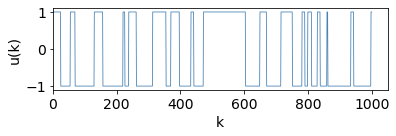

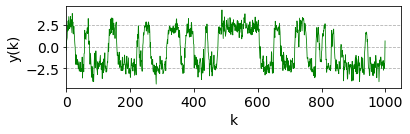

In [2]:
# read data and plot
data = np.loadtxt('ARX_illustrate_SNR10.csv', delimiter=',')
u = data[:,0, None]; y = data[:,1, None]

# plots
plt.figure(figsize=(6,1.5))
plt.plot(u, 'steelblue', linewidth=0.8)
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)

plt.figure(figsize=(6,1.5))
plt.plot(y, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [3]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False); u_centered = u_scaler.fit_transform(u) 
y_scaler = StandardScaler(with_std=False); y_centered = y_scaler.fit_transform(y) 

In [4]:
# fit OE model
OEmodel = SysID(y_centered, u_centered, 'OE', IC='AIC', nb_ord=[1,5], nf_ord=[1,5], delays=[0,5])
# SIPPY uses the symbol F to denote the denominator polynomial of transfer operator G
print(OEmodel.G)

suggested orders are: Na= 0 ; Nb= 1 ; Nc= 0 ; Nd= 0 ; Nf= 1 ; Delay:  0

  0.6704
----------
z - 0.7052

dt = 1.0



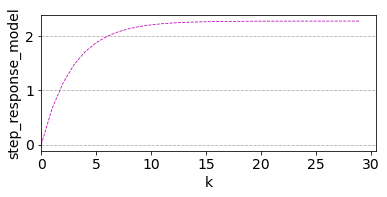

In [5]:
# generate step response of OE model
step_response_model, _ = control.matlab.step(OEmodel.G, T=30)

plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8)
plt.ylabel('step_response_model'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

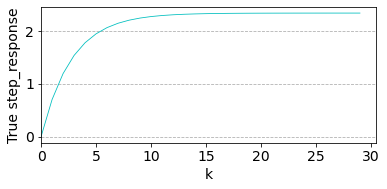

In [6]:
# generate step response of original process
# define the original process
NUM_G, DEN_G  = [0.7], [1, -0.7] 
sys_G = control.matlab.tf(NUM_G, DEN_G, 1)

# get step response
step_response_process, _ = control.matlab.step(sys_G, T=30)

plt.figure(figsize=(6,2.5))
plt.plot(step_response_process, 'c', linewidth=0.8)
plt.ylabel('True step_response'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

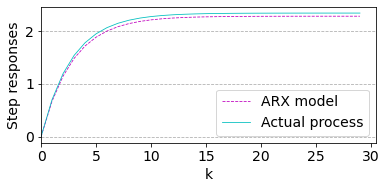

In [7]:
# overlay the step responses
plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8, label="ARX model")
plt.plot(step_response_process, 'c', linewidth=0.8, label="Actual process")
plt.ylabel('Step responses'), plt.xlabel('k'), plt.xlim(0), plt.legend()
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [7]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

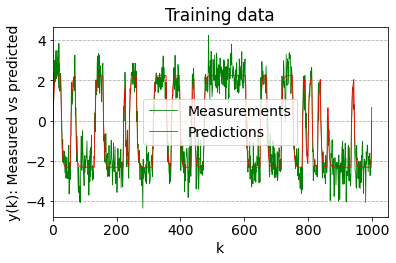

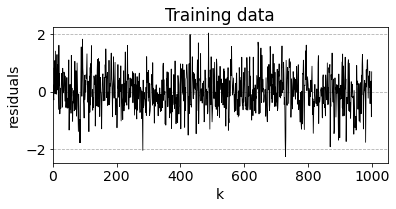

In [8]:
# get model predictions and residuals on training dataset
y_predicted_centered = OEmodel.Yid
y_predicted = np.transpose(y_scaler.inverse_transform(y_predicted_centered))
residuals = y - y_predicted

plt.figure(figsize=(6,3.5)), plt.plot(y, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(residuals, 'black', linewidth=0.8)
plt.title('Training data'), plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

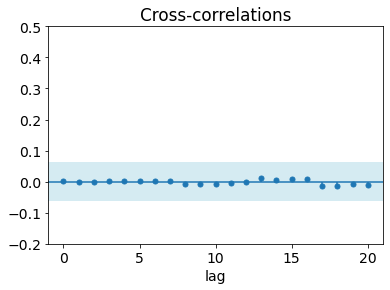

In [9]:
# CCF b/w residuals and input sequence
ccf_vals = ccf(residuals, u, adjusted=False) # ccf for lag >= 0
ccf_vals = ccf_vals[:21] # ccf for lag 0 to 20

# plot
conf_int = 1.96/np.sqrt(len(residuals))
lags = np.arange(0,21)

plt.figure(figsize=(6,4)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.2, 0.5) 
plt.show()

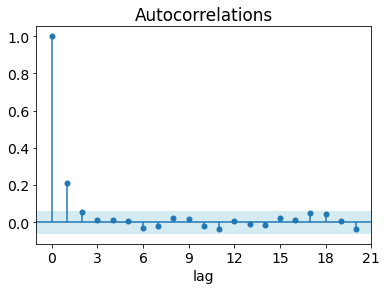

<Figure size 432x288 with 0 Axes>

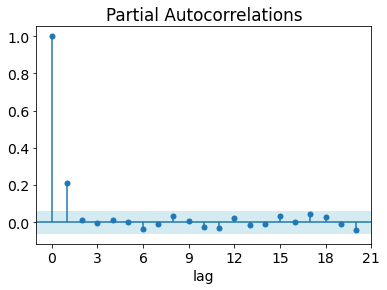

In [11]:
# ACF and PACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.ticker import MaxNLocator

plot_acf(residuals, lags= 20, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations')
plt.show()

plt.figure()
plot_pacf(residuals, lags= 20, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Partial Autocorrelations')
plt.show()